# Hyperparameter optimization

## Setup

In [1]:
# Install packages
#!pip install hyperopt
#!pip install git+https://github.com/hyperopt/hyperopt.git
#!pip install git+https://github.com/hyperopt/hyperopt-sklearn
#!pip install xgboost

In [2]:
# Libraries
## General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

## Model training and evaluation
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

## Classifiers
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt.pyll.stochastic
from hpsklearn import HyperoptEstimator, gradient_boosting_classifier, ada_boost_classifier,\
random_forest_classifier, logistic_regression, linear_discriminant_analysis # add more classifiers

## Misc
from statsmodels.stats.contingency_tables import mcnemar # McNemar test
import warnings
warnings.filterwarnings("ignore")

## Import the training and test data

In [3]:
# MM
train_df = pd.read_csv("clean_data/train.csv")
test_df = pd.read_csv("clean_data/test.csv")


y_train = train_df['compliance_2020']
X_train = train_df.drop(columns = ['compliance_2020', 'compliance_2021'])

# Test data
y_test = test_df['compliance_2020']
X_test = test_df.drop(columns = ['compliance_2020'])

# FŠ
#train_df = pd.read_csv("../clean/train_clean.csv", sep = ";")
#test_df = pd.read_csv("../clean/test_clean.csv", sep = ";")
#y_train = train_df['compliance']
#X_train = train_df.drop(columns = ['compliance'])
#X_test = test_df.drop(columns = ['compliance'])
#y_test = test_df['compliance']


print(f'X_train dims: {X_train.shape}')
print(f'y_train dims: {y_train.shape}')

#print(f'X_val dims: {X_val.shape}')
#print(f'y_val dims: {y_val.shape}')

print(f'X_test dims: {X_test.shape}')
print(f'y_test dims: {y_test.shape}')

X_train dims: (388, 27)
y_train dims: (388,)
X_test dims: (156, 27)
y_test dims: (156,)


## Hyperparameter optimization
The following section is divided into two parts: (1) the `hyperopt` approach and the `hyperopt-sklearn` approach. The difference between these two is that while `hyperopt` generally requires user-defined, manually mapped search spaces for model hyperparameters, `hyperopt-sklearn` also provides the possibility for not manually defining the search spaces, and making the searches on its own automatically.

#### Defining classifiers and their HPO search spaces
In order to provide somewhat more automation for this notebook, we provide the manually-defined search spaces for all algorithms that we used for the baseline model selection. The best five models are then selected from the lists below.

In [4]:
names = [
    "K-Nearest Neighbors",
    "SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
    "LDA",
    "Logistic Regression",
    "XGBoost",
    "SGD",
    "Gradient Boosting Classifier"
]

classifiers = [
    KNeighborsClassifier(),
    SVC(), # kernel = "rbf" by default
    GaussianProcessClassifier(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LinearDiscriminantAnalysis(),
    LogisticRegression(),
    XGBClassifier(),
    SGDClassifier(),
    GradientBoostingClassifier()
]

search_spaces = [
    
    # KNN
    {},
    
    #SVM
    {},
    
    # Gaussian Process
    {},
    
    # Decision Tree
    {},
       
    # Random Forest
    {
        'n_estimators': hp.choice('n_estimators', range(50, 250, 1)), # default=100
        'min_samples_split': hp.choice('min_samples_split', range(2, 7, 1)), # default=2
        'max_features': hp.choice('max_features', ['sqrt', 'log2']), # default='sqrt'
    },
    
    # AdaBoost
    {
        'learning_rate': hp.uniform('learning_rate', 0.001, 0.4), # default=1.0
        'n_estimators': hp.choice('n_estimators', range(50, 250, 1)), # default=100
        
    },
    
    # Naive Bayes
    {},
    
    # QDA
    {},
    
    # LDA
    {
        'solver': hp.choice('solver', ['lsqr', 'eigen']), # default=’svd’
        'shrinkage': hp.uniform('shrinkage', 0.01, 1), # default=None # not supported with 'svd' solver
        
    },
    
    # Logistic Regression
    { 
        'penalty': hp.choice('penalty', ['l1', 'l2', 'elasticnet', 'none']), # default=’l2’
        'l1_ratio': hp.uniform('l1_ratio', 0, 1),
        'C': hp.uniform('C', 0, 1), # default = 1.0
        'solver': hp.choice('solver', ['saga','saga'])  # # use solver = 'saga' for using different penalties (here, give a pseudo-choice)
    },
    
    # XGBoost
    {},
    
    # SGD
    {},

    # GBC
    {
        'learning_rate': hp.uniform('learning_rate', 0.001, 0.4), # default=0.1
        'n_estimators': hp.choice('n_estimators', range(50, 250, 1)), # default=100
        'subsample': hp.uniform('subsample', 0.01, 1), # default=1.0
        'max_depth': hp.choice('max_depth', range(1,20)), # default=3
        'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2']), # default=None
     #   'criterion': hp.choice('criterion', ["friedman_mse", "squared_error"]) # default=’friedman_mse’
    }
    

]

# Dataframe for model names, classes, and search spaces
df_models = pd.DataFrame({'name': names, 'classifier': classifiers, 'search_space' : search_spaces})
df_models['n_hp'] = df_models['search_space'].map(len) # the number of hyperparameters in search space


df_models = df_models.sort_values('n_hp', ascending = False) # model WILL BE sorted by accuracy (or ranking)

### The `hyperopt` approach
A great resource for hyperparameter optimization using the `hyperopt` library can be found [here](https://medium.com/district-data-labs/parameter-tuning-with-hyperopt-faa86acdfdce). The `hyperopt` Python module implements Bayesion Hyperparameter Optimization (HPO), and within this module, one needs to define manually the search space for a given model/classifier.

We will first select the best five baseline models from <font color = 'red'> REFER TO SECTION </font>.

In [5]:
# How many best baselines to choose?
n_best = 5

# Select the best baseline ('bl') classifiers and their (manually-defined) search spaces
df_best_bl = df_models.copy().iloc[:n_best,:].reset_index(drop = True)
df_best_bl

,name,classifier,search_space,n_hp
0,Gradient Boosting Classifier,GradientBoostingClassifier(),{'learning_rate': 0 float 1 hyperopt_param 2...,5
1,Logistic Regression,LogisticRegression(),{'penalty': 0 switch 1 hyperopt_param 2 ...,4
2,Random Forest,RandomForestClassifier(),{'n_estimators': 0 switch 1 hyperopt_param 2...,3
3,AdaBoost,AdaBoostClassifier(),{'learning_rate': 0 float 1 hyperopt_param 2...,2
4,LDA,LinearDiscriminantAnalysis(),{'solver': 0 switch 1 hyperopt_param 2 L...,2


With the following codeblock, we are implementing the HPO by iterating over the selected classifiers and their manually-defined search spaces.

In [26]:
# Initialize a dataframe for results collection
hpo_results = pd.DataFrame(columns = ['classifier_name', 'best_cv_score', 'runtime_hpo', 'best_params', 'test_acc'])

# Define the best baseline score
best_baseline_score = 0.906

# Define how many iterations should be done
n_trials = 100

# Trials list
trials_dict = {}

# Start the timer to measure the runtime of the entire pipeline
hpo_time_start = time.time()

# Run the HPO and get the best params for each classifier
for i in range(len(df_best_bl)):
    
    # To improve the raedability of code, creating the following objects:
    classifier_name = df_best_bl.loc[i, 'name']
    classifier_class = df_best_bl.loc[i, 'classifier']
    classifier_search_space = df_best_bl.loc[i, 'search_space']
    
  #  sp = search_spaces[names.index(df_best_bl.loc[i, 'name'])]
    
    # To improve the readability of output:
    print()
    print('----------------------------------------------------------------------')
    print(f'Using *{classifier_name}* for estimation.')
    print('----------------------------------------------------------------------')
    
    # A helper function for receiving the CV scores for each model
    def hyperopt_cv_score(params):
        cv = RepeatedKFold(n_splits=5, n_repeats=2) # can be also adjusted!dd
        model = classifier_class.set_params(**params) # use the classifier from the list
        return cross_val_score(model, 
                               X_train, y_train, 
                               cv = cv,  
                               scoring = 'accuracy',
                               error_score='raise').mean() 

    # A helper function for finding the best model
    def f(params):
        global best_cv_score
        global best_params
        global best_time
        
        cv_score = hyperopt_cv_score(params)
    
        if cv_score > best_cv_score:
            if cv_score > best_baseline_score:
                best_cv_score = cv_score # what is the best score?
                best_params = params # what are the best params?
                best_time = round(time.time() - start_time,4) # track how much time it took to find the best params
                
                print(f'*{classifier_name}* BEAT THE BASELINE of {best_baseline_score}!')
                print(f'Better CV score: {best_cv_score}')
                print(f'Parameter combination: {best_params}')
                print(f'Time until beating the baseline: {best_time}s')
            else: 
                best_cv_score = cv_score # what is the best score?
                best_params = params # what are the best params?
                best_time = round(time.time() - start_time,4) # track how much time it took to find the best params

                # Print the results for reference
                print(f'New best CV score: {best_cv_score}')
                print(f'New best params: {best_params}')
                print(f'Time taken until new best combination found: {round(best_time, 5)}s')

        return {'loss': -cv_score, # see the comment below
                'status': STATUS_OK}
        # Comment regarding 'negative cv_score' (from the referenced source):
        ## Since we are trying to maximize the CV score (cv_score in the code above), 
        ## we must negate this value for hyperopt, since hyperopt only knows how to minimize a function. 
        ## Minimizing a function f is the same as maximizing the negative of f.
        ## About FMIN: https://github.com/hyperopt/hyperopt/wiki/FMin
        
    # Defining global variables to be updated
    best_cv_score = 0 # best CV score
    best_params = None # best hyperparameter combination
    best_time = 0 # runtime until the best CV score is computed
    trials = Trials() # store info at each step
    
    # Start running the algorithm and track time
    start_time = time.time()
    ## Objective function
    best = fmin(f, 
                classifier_search_space, # use the search space associated with the classifier
                algo = tpe.suggest, 
                max_evals = n_trials, # how many evaluations?
                trials = trials)
    trials_dict[classifier_name] = trials # save into classifier-trials 
    
    print()
    print(f'Best CV score in {n_trials} iterations: {best_cv_score} ({best_time}s until found).')
    
    # save trials
    
    
    # Compute the accuracy score on the best model of the classifier
    m = classifier_class.set_params(**best_params).fit(X_train, y_train)
    score_test = m.score(X_test, y_test)
    print(f'Accuracy score on test data: {score_test}.')
    
    
    # Append the best results to the df
    hpo_results = hpo_results.append({'classifier_name': classifier_name, 
                             'best_cv_score': best_cv_score, 
                             'runtime_hpo': best_time, 
                             'best_params': best_params,
                             'test_acc': score_test}, ignore_index = True)

# Mark the end of the entire pipeline
hpo_time_end = time.time()
print()
print(f'The duration of the entire HPO pipeline for {len(df_best_bl)} classifiers across {n_trials} trials each: ')
print(f'{round(hpo_time_end - hpo_time_start, 5)} seconds')

# Sort the model results by test accuracy score and then Runtime
hpo_results = hpo_results.sort_values(['test_acc', 'runtime_hpo'], ascending = [0,1]).reset_index(drop = True)


----------------------------------------------------------------------
Using *Gradient Boosting Classifier* for estimation.
----------------------------------------------------------------------
New best CV score: 0.8596237096237097                                           
New best params: {'learning_rate': 0.15307543272504298, 'max_depth': 2, 'max_features': 'auto', 'n_estimators': 232, 'subsample': 0.8955670615084173}
Time taken until new best combination found: 1.55s                              
New best CV score: 0.860905760905761                                            
New best params: {'learning_rate': 0.21882790520787393, 'max_depth': 6, 'max_features': 'log2', 'n_estimators': 224, 'subsample': 0.4528933229703287}
Time taken until new best combination found: 4.9712s                            
New best CV score: 0.8698801198801197                                           
New best params: {'learning_rate': 0.31197553089635227, 'max_depth': 2, 'max_features': 'auto', 'n_

New best params: {'shrinkage': 0.5859695310710624, 'solver': 'lsqr'}            
Time taken until new best combination found: 0.5922s                            
New best CV score: 0.8531635031635032                                           
New best params: {'shrinkage': 0.6107898198353972, 'solver': 'eigen'}           
Time taken until new best combination found: 1.0036s                            
100%|██████| 100/100 [00:02<00:00, 33.57trial/s, best loss: -0.8531635031635032]

Best CV score in 100 iterations: 0.8531635031635032 (1.0036s until found).
Accuracy score on test data: 0.8846153846153846.

The duration of the entire HPO pipeline for 5 classifiers across 100 trials each: 
466.63649 seconds


In [27]:
# HPO results (sorted by test accuracy and runtime)
hpo_results

,classifier_name,best_cv_score,runtime_hpo,best_params,test_acc
0,AdaBoost,0.875042,40.0682,"{'learning_rate': 0.044931293434935154, 'n_est...",0.916667
1,Random Forest,0.884099,69.3654,"{'max_features': 'sqrt', 'min_samples_split': ...",0.903846
2,Gradient Boosting Classifier,0.881385,70.8232,"{'learning_rate': 0.26627591621993674, 'max_de...",0.897436
3,LDA,0.853164,1.0036,"{'shrinkage': 0.6107898198353972, 'solver': 'e...",0.884615
4,Logistic Regression,0.846703,2.6564,"{'C': 0.20301137574257805, 'l1_ratio': 0.07887...",0.871795


Let's plot the model test set accuracy against runtime.

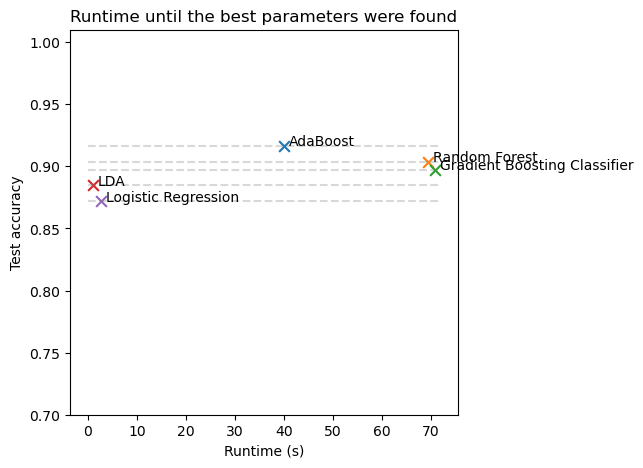

In [28]:
plt.figure(figsize = [5, 5])

for i in range(len(hpo_results)):
    # Add classifier values
    plt.scatter(hpo_results['runtime_hpo'][i], 
            hpo_results['test_acc'][i], 
            label = hpo_results['classifier_name'][i],
               marker = 'x',
               s = 60)
    # Add a dashed lined marking the best accuracy threshold for classifier
    plt.hlines(y = hpo_results['test_acc'][i], 
               xmin=0, 
               xmax = np.max(hpo_results['runtime_hpo'])+1,
              linestyles = 'dashed', alpha = 0.3, color = 'grey')
    # Add classifier name
    plt.annotate(hpo_results['classifier_name'][i], 
                 (hpo_results['runtime_hpo'][i]+1, 
                  hpo_results['test_acc'][i]),
                )
plt.ylim(bottom = 0.70, top = 1.01)
plt.xlabel('Runtime (s)')
plt.ylabel('Test accuracy')
plt.title('Runtime until the best parameters were found')
plt.show();

In addition to displaying the best accuracies and runtimes of each classifier, let's also look into how the accuracy scores were associated with different values of hyperparameters. For that, we first define a helper function that take classifier and its trials' related information as input and provides the parameter value-accuracy figure as output. We then iterate over all models to display the values of parameters in relation to accuracy scores accross all trials.

In [29]:
def params_plot(classifier_name, trials, parameters):
    """Parameters plot from trials
    Args:
        classifier_name (str): the name of the classifier
        trials (trials obj): all trials from runs
        parameters (list): list of parameters to be plotted
    
    Returns: 
        plot for parameter performance across trials
    """
    # Define the figure (make a 2x3 grid universally)
    f, axes = plt.subplots(nrows=2, ncols=3, figsize=(8,5))
    f.suptitle(f'{classifier_name} HP performance across {len(trials)} trials') # set the plot title
    f.tight_layout()

    cmap = plt.cm.jet
    for i, val in enumerate(parameters):
        # Getting the hyperparameter and loss values with list comprehension
        xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
        ys = [-t['result']['loss'] for t in trials.trials]
        # Making the necessary sorting
        xs, ys =  zip(*sorted(zip(xs, ys)))
        ys = np.array(ys)

        # Plot
        axes[int(i/3),int(i%3)].scatter(xs, ys, 
                              s=20, 
                              linewidth=0.01, 
                             # alpha= 0.5,
                              color=cmap(float(i)/len(parameters))
                                       )
        axes[int(i/3),int(i%3)].set_title(val)
        axes[int(i/3),int(i%3)].set_ylim([0.2,1.0])

    plt.show();

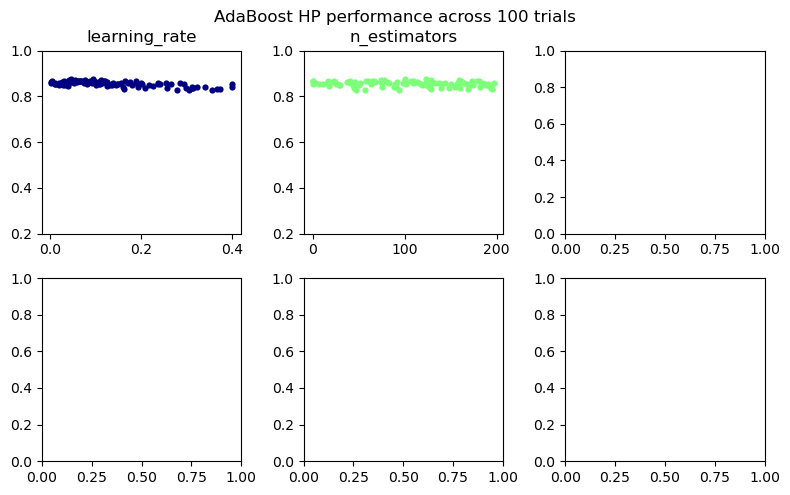

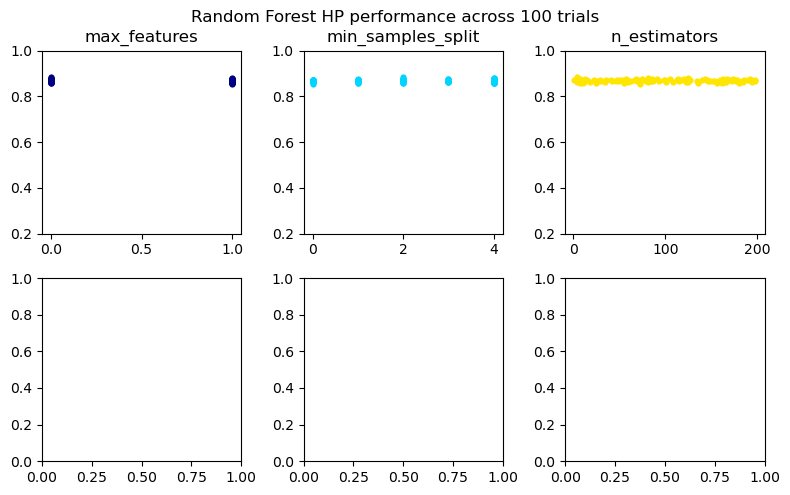

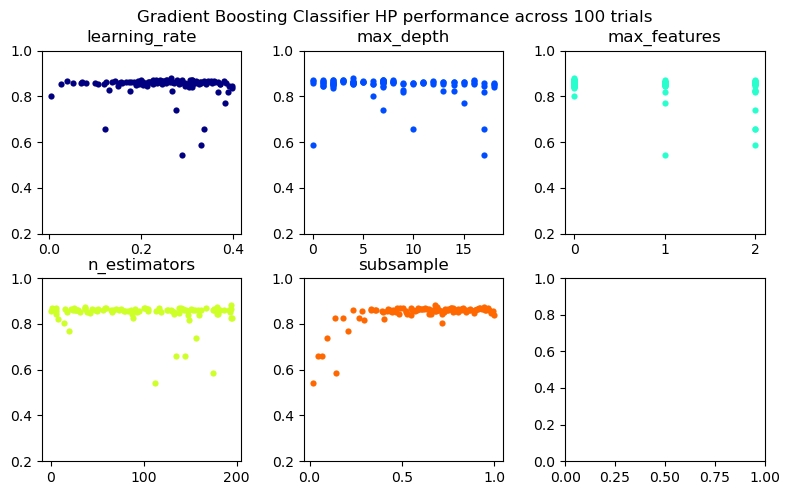

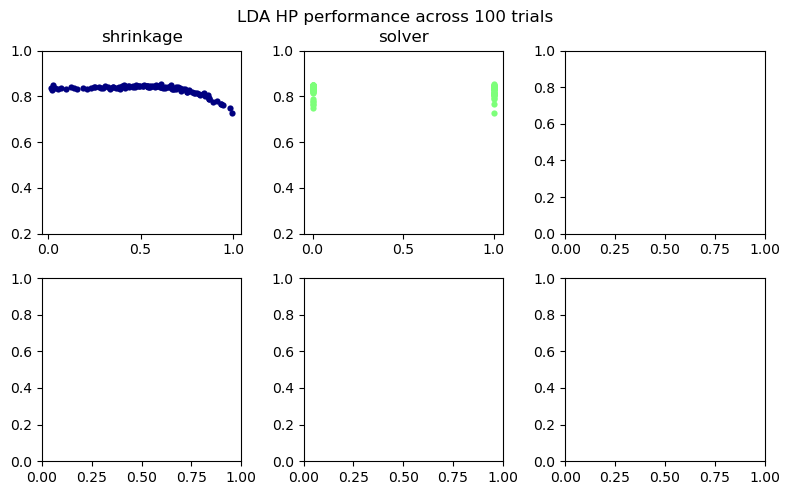

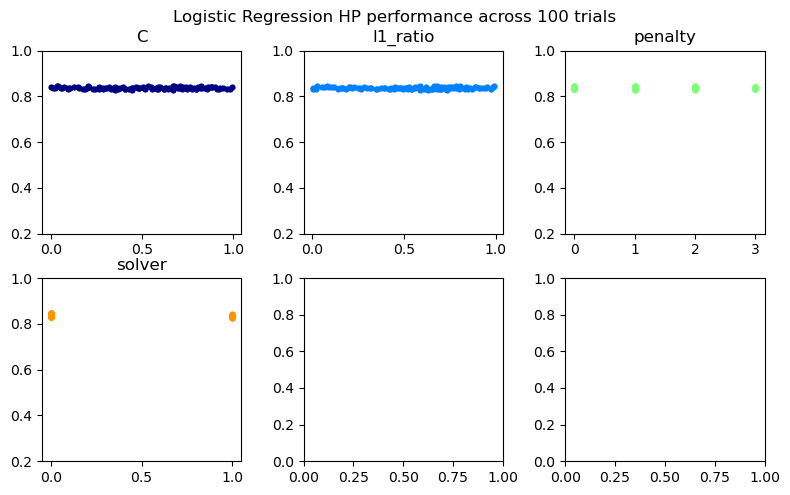

In [30]:
for i in range(len(hpo_results)):
    classifier_name = hpo_results.loc[i, 'classifier_name']
    trials = trials_dict[classifier_name]
    parameters = hpo_results.loc[i, 'best_params'].keys()
    params_plot(classifier_name, trials, parameters)

## The `hyperopt-sklearn` approach
In <font color = 'red'> SECTION </font>, we provided the definition for the search space of each selected classifier. However, `hyperopt` can also function without explicitly specifying the search space - enter `hyperopt-sklearn`, a presently developed library (see [here](https://github.com/hyperopt/hyperopt-sklearn)) that provides more automation for hyperparameter optimization. `hyperopt-sklearn` has support for a deecnt number of classifiers, it allows to automatically search for the best models from either within all possible model classes or from a user-defined set of models; it is possible to implement data preprocessing (a functionality that we decided not to use during the present project) as well as define the search space manually or let the computer decide it randomly based on all possible hyperparameters. 

Below we will run the classifiers used above without specified search space. Of note, this might mean that some models will not compute or converge, since some hyperparameter combinations do not work together. In those cases, we just skip the hyperparameter combination and proceed.

The main advantage of `hyperopt-sklearn` is that we can reduce manual work in specifying hyperparameter space for each classifier. The main disadvantage is that some of the previously-used functions are not easily programmable here, i.e., the `hypropt-sklearn` is somewhat less flexible.

In [ ]:
# 1. Initialize a dataframe
model_results_auto = pd.DataFrame(columns = ['classifier', 'test_acc', 'best_params'])

# 2. Classifier labels
names_auto = [
    "Gradient Boosting Classifier",
    "LDA",
    "Random Forest",
    "AdaBoost",
    "Logistic Regression"
]

# 3. Classifier classes
classifiers_auto = [
    gradient_boosting_classifier("gbc"),
    linear_discriminant_analysis('lda'),
    random_forest_classifier('rf'), 
    ada_boost_classifier('ada'), 
    logistic_regression('logreg')
]

# 4. Iterate over all classifiers
for i in range(len(classifiers_auto)):
    print()
    print(f'Using the *{names_auto[i]}* for estimation.')
    
    # Objective function
    estim = HyperoptEstimator(classifier = classifiers_auto[i],
                                    #  preprocessing=[],
                                      algo=tpe.suggest,
                                      max_evals=100)
    try:
        # Fit the model
        estim.fit(X_train, y_train)
        
        # Add the results to df
        model_results_auto = model_results_auto.append(
            {'classifier': names_auto[i], 
            # 'runtime_hpo': best_time,
             'test_acc': estim.score(X_test, y_test),
             'best_params': estim.best_model()
             }, 
            ignore_index = True)
    except:
        print('Model with params not computed')
        # Append the name but assign None-values to fields
        model_results_auto = model_results_auto.append(
            {'classifier': names_auto[i], 
            # 'runtime_hpo': best_time,
             'test_acc': None,
             'best_params': None
             }, 
            ignore_index = True)

model_results_auto = model_results_auto.sort_values(['test_acc'], ascending = False).reset_index(drop = True)

Look at the results table:

In [ ]:
model_results_auto

# Significance testing 
In the below section, we will test whether the differences between the models are statistically significant. For that, we will use pairwise McNemar test to compare each model with each other. P-values have the continuity correction.

We first start by defining the helper function for the pairwise McNemar test.

## Bonus: Kaggle submission
Below is a little piece of code for external model validation with a holdout test set on Kaggle.